# EDA IBM stock 1min ticks

## Takeouts -  december 29/2019
* The distribution of the difference of the time series has very long tails: see plot. This was expected; still very ugly.
* Created a very clean dataset with 'pastValues', 'currentValue', 'futureValue', 'deltaMinutes'. 
* The precision recall curve that we already have looks quite good: we trained one single time.

## Takeouts -  december 30/2019
* Plot a precision recall curve with several(monthly/weekly) training batches

## Takeouts January 4/2020
* Models are apparently ok the baseline is definitely improved.
* Lets start turning them into a deployable strategy, maybe try to get alpha on top of DowJones?
* We could encode time way better.


* Need a more elaborated way of looking at histograms: the tails don't let me see anything: those tails are a huge concern.
* Look out for sklearn methods to do crossvalidation in our setting: do not reinvent the wheel.

In [148]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [149]:
from modeling.dataSetUtilities import createTrainingDataSet
from modeling.generatePipeline import generatePipeline

In [102]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier ## might not be necessary in the future?

In [103]:
names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.read_csv('data/sampleKibotData/minuteIntraday/IBM_adjusted.txt', header=None, names=names)
df['DateTime']= pd.to_datetime((df.Date+' '+df.Time),infer_datetime_format=True) 
df = df.drop(columns=['Date', 'Time'])
df = df.set_index('DateTime')


In [104]:
df.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
1998-01-02 09:30:00,33.69,33.69,33.69,33.69,207820
1998-01-02 09:31:00,33.65,33.69,33.65,33.65,33499
1998-01-02 09:32:00,33.67,33.69,33.65,33.69,41254
1998-01-02 09:33:00,33.67,33.69,33.65,33.65,52110
1998-01-02 09:34:00,33.65,33.69,33.65,33.65,14892


In [105]:
df = df[-10000:]

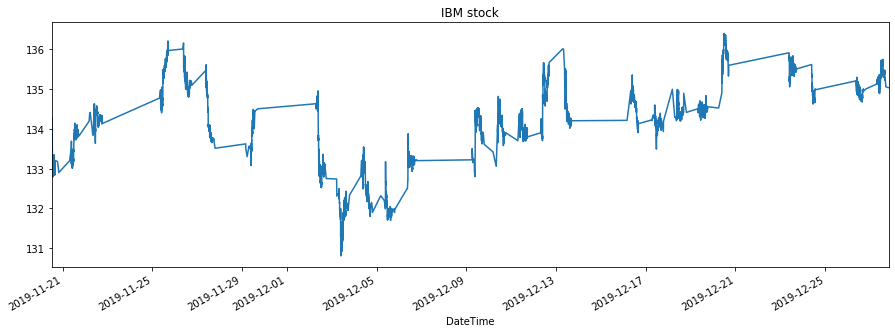

In [106]:
#df.head()
df.Open.plot(figsize=(15,5), title='IBM stock');
#df.index.map(lambda x: x.year).value_counts().sort_index().plot.bar(figsize=(15, 5), title='ticks per year');
#df.Open.diff().plot.hist(bins=200, figsize=(15,5), title= 'distribution of the differential');
#pd.Series(df.index.map(lambda x: x.day)).value_counts().sort_index().plot.bar()

In [107]:
dg  = createTrainingDataSet(df, presentStart=1, pastStart=5, futureEnd=-30)

In [108]:
dg.target.value_counts()

False    4500
True     4160
Name: target, dtype: int64

In [109]:
X = dg.copy()
y = X.pop('target')

In [110]:
X.shape

(8660, 7)

In [111]:
X.head()

,DateTime,Open,High,Low,Close,Volume,unthresholdedTarget
DateTime,,,,,,,
2019-11-20 12:28:00,"[2019-11-20 12:23:00, 2019-11-20 12:24:00, 201...","[134.26, 134.279, 134.23, 134.24, 134.2358, 13...","[134.275, 134.279, 134.26, 134.25, 134.2408, 1...","[134.25, 134.2, 134.23, 134.23, 134.21, 134.16]","[134.26, 134.21, 134.26, 134.2388, 134.2103, 1...","[925.0, 2946.0, 1224.0, 1016.0, 3939.0, 4857.0]",-0.000547
2019-11-20 12:29:00,"[2019-11-20 12:24:00, 2019-11-20 12:25:00, 201...","[134.279, 134.23, 134.24, 134.2358, 134.225, 1...","[134.279, 134.26, 134.25, 134.2408, 134.24, 13...","[134.2, 134.23, 134.23, 134.21, 134.16, 134.188]","[134.21, 134.26, 134.2388, 134.2103, 134.185, ...","[2946.0, 1224.0, 1016.0, 3939.0, 4857.0, 1281.0]",-0.000675
2019-11-20 12:30:00,"[2019-11-20 12:25:00, 2019-11-20 12:26:00, 201...","[134.23, 134.24, 134.2358, 134.225, 134.188, 1...","[134.26, 134.25, 134.2408, 134.24, 134.24, 134...","[134.23, 134.23, 134.21, 134.16, 134.188, 134.2]","[134.26, 134.2388, 134.2103, 134.185, 134.2339...","[1224.0, 1016.0, 3939.0, 4857.0, 1281.0, 8150.0]",-0.000933
2019-11-20 12:31:00,"[2019-11-20 12:26:00, 2019-11-20 12:27:00, 201...","[134.24, 134.2358, 134.225, 134.188, 134.2226,...","[134.25, 134.2408, 134.24, 134.24, 134.25, 134...","[134.23, 134.21, 134.16, 134.188, 134.2, 134.205]","[134.2388, 134.2103, 134.185, 134.2339, 134.22...","[1016.0, 3939.0, 4857.0, 1281.0, 8150.0, 917.0]",-0.001147
2019-11-20 12:32:00,"[2019-11-20 12:27:00, 2019-11-20 12:28:00, 201...","[134.2358, 134.225, 134.188, 134.2226, 134.214...","[134.2408, 134.24, 134.24, 134.25, 134.26, 134...","[134.21, 134.16, 134.188, 134.2, 134.205, 134.21]","[134.2103, 134.185, 134.2339, 134.22, 134.26, ...","[3939.0, 4857.0, 1281.0, 8150.0, 917.0, 1905.0]",-0.001319


## A precision recall-curve with only one training split.

In [112]:
# temporal split of train/test
trainPercentage = 50
testBegins = (len(X)*trainPercentage)//100
Xtrain, ytrain = X[:testBegins], y[:testBegins]
Xtest, ytest = X[testBegins:], y[testBegins:]

In [113]:
model = generatePipeline()
model.fit(Xtrain, ytrain)

/Users/lduque/Desktop/MyProjects/moneyManager/venv-money/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('selectcolumns',
                 ColumnSelector(columns=['Open', 'High', 'Low', 'Close',
                                         'Volume'])),
                ('scaletimeseries',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function timeSeriesScaler at 0x11bb71158>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('featurengineering',
                 FunctionTransformer(accept_spars...
                 TransformationWrapper(transformation=MinMaxScaler(copy=True,
                                                                   feature_range=(0,
                                                                                  1)))),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                          

In [125]:
# how to pick a threshold? classic Luis!
ypredictedTrain=list(model.predict_proba(Xtrain)[:,1])

In [127]:
ypredictedTrain.sort(reverse=True)

In [130]:
threshold = ypredictedTrain[100]

In [131]:
threshold

0.6903268450251033

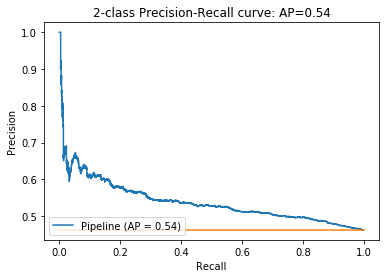

In [132]:
base_rate = sum(ytest)/len(ytest)
ypredicted=model.predict_proba(Xtest)[:,1]
average_precision = average_precision_score(ytest, ypredicted)
disp = plot_precision_recall_curve(model, Xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.plot([0, 1], [base_rate, base_rate]);

In [133]:
evaluationDF = pd.DataFrame({'predicted':ypredicted, 'target':ytest, 'unthresholdedTarget':Xtest.unthresholdedTarget}, index=Xtest.index)

#topPredictions = evaluationDF.sort_values(by='predicted', ascending=False)[:100]

In [135]:
evaluationDF['thresholdedPrediction']=evaluationDF.predicted>threshold

In [137]:
topPredictions=evaluationDF[evaluationDF.thresholdedPrediction==True]

In [138]:
topPredictions

,predicted,target,unthresholdedTarget,thresholdedPrediction
DateTime,,,,
2019-12-10 11:26:00,0.731296,True,0.001164,True
2019-12-10 11:40:00,0.703573,False,-0.000067,True
2019-12-10 15:13:00,0.715737,False,-0.000841,True
2019-12-11 09:48:00,0.725960,True,0.000653,True
2019-12-11 10:38:00,0.727518,False,-0.000289,True
...,...,...,...,...
2019-12-26 11:10:00,0.702488,True,0.000235,True
2019-12-27 09:52:00,0.725944,False,-0.001808,True
2019-12-27 10:20:00,0.703311,True,0.000528,True


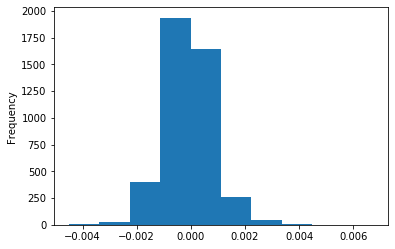

In [139]:
evaluationDF.unthresholdedTarget.plot.hist()

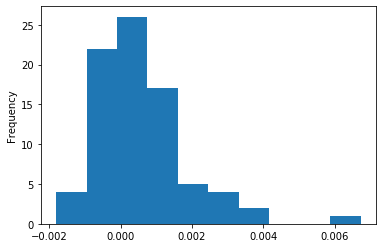

In [140]:
topPredictions.unthresholdedTarget.plot.hist()

In [141]:
print(evaluationDF.unthresholdedTarget.mean())
print(topPredictions.unthresholdedTarget.mean())

-7.648035285351987e-05
0.0005895098475111709


In [142]:
print(evaluationDF.unthresholdedTarget.median())
print(topPredictions.unthresholdedTarget.median())

-9.216668721578544e-05
0.0004563512901693121


In [144]:
topPredictions.shape

(81, 4)

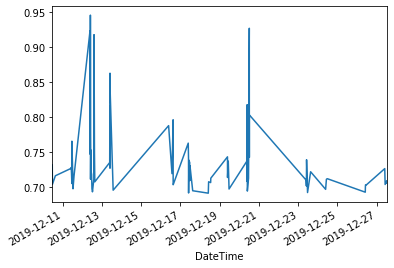

In [145]:
topPredictions.predicted.sort_index().plot()

In [146]:
## now lets do the same but predict when performance is going to be below median
ytrain_neg = ~(ytrain)
ytest_neg = ~(ytest)
model = generatePipeline()
model.fit(Xtrain, ytrain_neg)

/Users/lduque/Desktop/MyProjects/moneyManager/venv-money/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('selectcolumns',
                 ColumnSelector(columns=['Open', 'High', 'Low', 'Close',
                                         'Volume'])),
                ('scaletimeseries',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function timeSeriesScaler at 0x11bb71158>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('featurengineering',
                 FunctionTransformer(accept_spars...
                 TransformationWrapper(transformation=MinMaxScaler(copy=True,
                                                                   feature_range=(0,
                                                                                  1)))),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                          

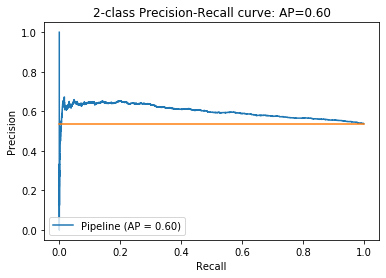

In [147]:
base_rate = sum(ytest_neg)/len(ytest_neg)
ypredicted_neg=model.predict_proba(Xtest)[:,1]
average_precision = average_precision_score(ytest_neg, ypredicted_neg)
disp = plot_precision_recall_curve(model, Xtest, ytest_neg)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.plot([0, 1], [base_rate, base_rate]);

# A precision-recall curve with multiple training batches: this probably needs some rewriting ! (maybe with crossvalidation?)

In [ ]:
X = pd.concat([dg.pastValues.apply(lambda x:pd.Series(x)), dg.currentValue, dg.target], axis=1)
firstTimeStamp=X.index[0]
first_day = datetime(firstTimeStamp.year, firstTimeStamp.month, firstTimeStamp.day)
X['week']=pd.Series(X.index).apply(lambda x: (datetime(x.year, x.month, x.day)-first_day).days//7).values

In [ ]:
# notice that for the week zero we wont have a model.
trainSets = [X[X.week==w] for w in X.week.unique()]
trainTestBarches = [(None, None, None, None)]+[(trainSets[i].drop(columns='target'),trainSets[i].target,trainSets[i+1].drop(columns='target'),trainSets[i+1].target) for i in range(len(trainSets)-1)]
models = [None] + [GridSearchCV(regr, parameters, cv=2, scoring='average_precision') for _ in range(len(trainSets)-1)]

In [ ]:
Xtrain, ytrain, Xtest, ytest = trainTestBarches[1]

In [ ]:
Xtrain # notice: week should not be in the model, but its ok for now

In [ ]:
for i in range(1, len(models)):
    print(i)
    Xtrain, ytrain, Xtest, ytest = trainTestBarches[i]
    models[i].fit(Xtrain.div(Xtrain.currentValue, axis=0), ytrain)

In [ ]:
# this function is worth saving somewhere !
def indexedModelEvaluation(x):
    row = x.copy()
    week = row['week']
    row = row.drop('target')
    row = [list(row/row.currentValue)]
    model = models[week]
    return np.nan if model==None else model.predict_proba(row)[0][1]

In [ ]:
ypredicted = X.apply(indexedModelEvaluation,axis=1)

In [ ]:
X['predicted']=ypredicted

In [ ]:
dh = X[['predicted', 'target']].copy()

In [ ]:
dh = dh[dh.predicted.notna()] 

In [ ]:
ytest = dh.target
ypredicted = dh.predicted
base_rate = sum(ytest)/len(ytest)
average_precision = average_precision_score(ytest, ypredicted)
precision, recall, _ = precision_recall_curve(ytest, ypredicted)

In [ ]:
plt.plot(recall, precision)
plt.plot([0, 1], [base_rate, base_rate]);

In [ ]:
A = [-1, -1, -1, -1, -1 ,6,7,8,9,10]

In [ ]:
np.percentile(A, 100)

In [ ]:
np.median(A)